<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Histopathologic_Cancer_Detection/HCD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
!pip install keras-tuner -q
from keras_tuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import pickle
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from keras.callbacks import ReduceLROnPlateau
import cv2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Initialize variables

In [24]:
initial_dir = '/content/gdrive/MyDrive/Histopath'  # Mandatory update

def append_ext(file):
  return file + '.tif'

def remove_ext(file):
  return file.split('.')[0]

df = pd.read_csv('{}/train_labels.csv'.format(initial_dir))
picdict = dict(zip(df['id'], df['label']))
state = 60
target_size = (96, 96)
class_mode = 'binary'
source_folder = '{}/train'.format(initial_dir)
home_dir = '{}/Full_set'.format(initial_dir)
save_dir = '{}/Saved_models'.format(initial_dir)

In [ ]:
tif_source_list = os.listdir(source_folder)

In [ ]:
source_list = map(remove_ext, tif_source_list)

# View data

In [12]:
def absolute_value(val):
  num = int(np.round(val/100 * len(df)))
  return num

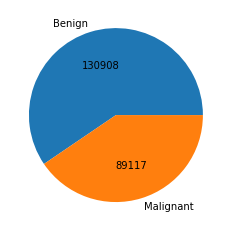

In [13]:
plt.pie(df['label'].value_counts(), 
        labels=['Benign', 'Malignant'],
        autopct=absolute_value)
plt.show()

# Process data

In [ ]:
sample_size = 80000 

# Sample a number of each label type
df_0_train = df[df['label'] == 0].sample(sample_size)
df_1_train = df[df['label'] == 1].sample(sample_size)

# Put into single dataframe
df_train_full = pd.concat([df_0_train, df_1_train], axis=0).reset_index(drop=True)

# Add the extension
df_train_full['id'] = df_train_full['id'].apply(append_ext)

# Shuffle the dataframe
df_train_full = shuffle(df_train_full)

In [ ]:
# Split into train, valid split lists
df_train, df_valid = train_test_split(df_train_full, 
                                      test_size=10000, 
                                      random_state=state, 
                                      stratify=df_train_full['label'])
train_list = list(df_train['id'])
valid_list = list(df_valid['id'])

# Make sure lists have correct # of elements
print(len(train_list), len(valid_list))
assert (len(train_list) + len(valid_list)) == (2 * sample_size)

150000 10000


Set data folder variables

In [ ]:
# Update these variables according to the dataset to use
train_comp = '{}/Train'.format(home_dir)
valid_comp = '{}/Valid'.format(home_dir)
benign_train_comp = '{}/Benign'.format(train_comp)
benign_valid_comp = '{}/Benign'.format(valid_comp)
mal_train_comp = '{}/Malignant'.format(train_comp)
mal_valid_comp = '{}/Malignant'.format(valid_comp)

Folder creation before split data

In [ ]:
os.mkdir(home_dir)
os.mkdir(train_comp)
os.mkdir(valid_comp)
os.mkdir(benign_train_comp)
os.mkdir(benign_valid_comp)
os.mkdir(mal_train_comp)
os.mkdir(mal_valid_comp)

This function splits the dataset into malignant and benign

In [ ]:
def split_data(LIST, SOURCE, MAL_FOLDER, BENIGN_FOLDER):
  for fname in LIST:
    origin = '{}/{}'.format(SOURCE, fname)
    name = remove_ext(fname)
    if picdict[name] == 0:
      shutil.copy(src=origin, dst=BENIGN_FOLDER)
    else:
      shutil.copy(src=origin, dst=MAL_FOLDER)

Execute the data split

In [ ]:
split_data(LIST=valid_list, SOURCE=source_folder, MAL_FOLDER=mal_valid_comp, BENIGN_FOLDER=benign_valid_comp)
split_data(LIST=train_list, SOURCE=source_folder, MAL_FOLDER=mal_train_comp, BENIGN_FOLDER=benign_train_comp)

This file was found to be corrupt during training

In [ ]:
bad_file = f'{mal_train_comp}/cd0e59e19393ad3545664a31b149f15ef2f909c2.tif'
os.remove(bad_file)

Data Augmentation

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_comp,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1/255.0)  

validation_generator = validation_datagen.flow_from_directory(
    valid_comp,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary') 

# Define and execute the model

In [ ]:
state = 75

tf.keras.backend.clear_session()
tf.random.set_seed(state)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            input_shape=(96, 96, 3), 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=128, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.5,
                              patience=1,
                              cooldown=2,
                              min_lr=1e-4
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/bestmodel.h5'.format(save_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [mc, reduce_lr]

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=cd
                    )

Epoch 1/20
4688/4688 [==============================] - ETA: 0s - loss: 0.4019 - acc: 0.8224
Epoch 00001: val_acc improved from -inf to 0.66470, saving model to /content/gdrive/MyDrive/Histopath/Saved_models/6Layer_bestmodel_011722.h5
4688/4688 [==============================] - 29508s 6s/step - loss: 0.4019 - acc: 0.8224 - val_loss: 1.0687 - val_acc: 0.6647 - lr: 0.0050
Epoch 2/20
4688/4688 [==============================] - ETA: 0s - loss: 0.3322 - acc: 0.8580
Epoch 00002: val_acc improved from 0.66470 to 0.69300, saving model to /content/gdrive/MyDrive/Histopath/Saved_models/6Layer_bestmodel_011722.h5
4688/4688 [==============================] - 1589s 339ms/step - loss: 0.3322 - acc: 0.8580 - val_loss: 0.8684 - val_acc: 0.6930 - lr: 0.0050
Epoch 3/20
4688/4688 [==============================] - ETA: 0s - loss: 0.2992 - acc: 0.8759
Epoch 00003: val_acc did not improve from 0.69300
4688/4688 [==============================] - 1444s 308ms/step - loss: 0.2992 - acc: 0.8759 - val_loss: 1

# Get Predictions and create Submission CSV file

In [ ]:
model = load_model('{}/bestmodel.h5'.format(save_dir))
y_pred = pd.read_csv('{}/sample_submission.csv'.format(initial_dir))
test_comp = '{}/test'.format(initial_dir)
y_pred['id'] = y_pred['id'].apply(append_ext)

In [ ]:
test_files = pd.DataFrame({'file_name': os.listdir(test_comp)})

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0)  

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=test_comp,
    x_col='file_name',
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False) 

Found 57458 validated image filenames.


In [ ]:
len_test = len(test_files)
len_test

57458

In [ ]:
preds = model.predict(test_generator,
                      steps=len_test,
                      verbose=1)

57458/57458 [==============================] - 11144s 194ms/step


Process the prediction labels

In [ ]:
preds = preds[:, 0]
preds = np.round(preds)
preds.astype(int)

array([0, 1, 1, ..., 0, 0, 1])

Merge the prediction labels into the submission dataframe

In [ ]:
test_file_names = test_generator.filenames
df_preds = pd.DataFrame({'id': test_file_names, 'label': preds})
y_pred = y_pred.merge(df_preds, on='id')

Get submission dataframe into correct format

In [ ]:
y_pred['label'] = y_pred['label_y']
y_pred.drop(['label_x'], axis=1, inplace=True)
y_pred.drop(['label_y'], axis=1, inplace=True)
y_pred['id'] = y_pred['id'].apply(remove_ext)

Please submit the below CSV to Kaggle for scoring.

In [ ]:
y_pred.to_csv('{}/sample_submission.csv'.format(initial_dir), index=False)

# Get AUC

In [ ]:
val_test_generator = validation_datagen.flow_from_directory(
    valid_comp,
    target_size=target_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False) 

Found 10000 images belonging to 2 classes.


In [ ]:
len_val_test = len(val_test_generator)

val_test_pred = model.predict(val_test_generator, 
                         steps=len_val_test,
                         verbose=1)[:, 0]

10000/10000 [==============================] - 2117s 212ms/step


In [ ]:
val_test_true = val_test_generator.classes
val_test_pred = np.round(val_test_pred)
val_test_pred.astype(int)

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
acc_val_test = np.equal(val_test_pred, val_test_true).sum() / len(val_test_pred)
print('Validation accuracy: {:.3f}'.format(acc_val_test))

Validation accuracy: 0.916


In [ ]:
fpr, tpr, thresholds = roc_curve(val_test_true, val_test_pred)

In [ ]:
auc_val_test = auc(fpr, tpr)
print('Validation AUC: {:.3f}'.format(auc_val_test))

Validation AUC: 0.916
